In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

folder_path = "/content/drive/My Drive/DL-Project"
os.chdir(folder_path)

Mounted at /content/drive


# Importing Necessary Libs

In [ ]:
import numpy as np
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Loading the Data

11490434/11490434 [==============================] - 0s 0us/step


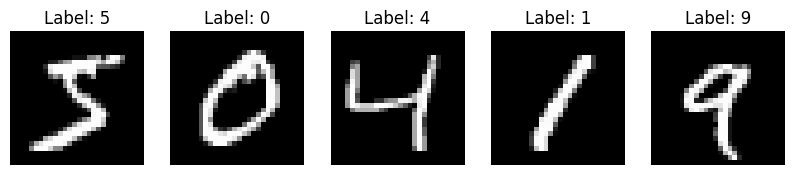

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Display sample images
num_samples = 5

plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

In [ ]:
# Reshape the image data to two-dimensional arrays
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Scale the pixel values to the range of 0 to 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Exp 0: Multi-Layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=100)


history = mlp.fit(X_train, y_train)

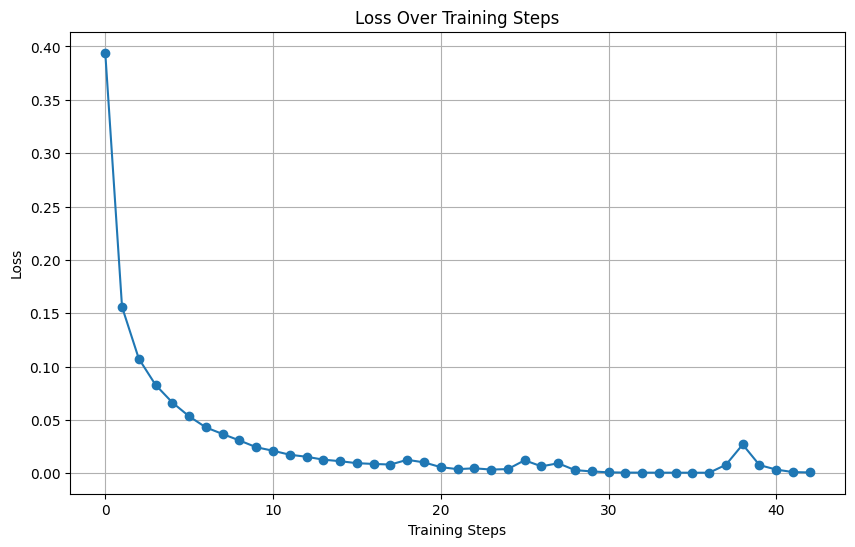

In [ ]:
# Get the loss values from the training history
loss_values = history.loss_curve_

# Plot the loss over training steps
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='o')
plt.title('Loss Over Training Steps')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('plots/mlp_loss_plot_Exp00.png')
plt.show()

In [ ]:
#Predicting on test data
y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
correct = int(accuracy*X_test.shape[0])
print("Accuracy on Test Set: ", accuracy*100)
print('Number of Correctly Classified Samples:', correct)
print('Number of Missclassified Samples:', X_test.shape[0]-correct)

Accuracy on Test Set:  98.17
Number of Correctly Classified Samples: 9817
Number of Missclassified Samples: 183


In [ ]:
pkl.dump(mlp, open("models/MultiLayer_Perceptron.pkl", 'wb'))

# Splitting Data into Train/Cross-Validation/Test sets

In [ ]:
validation_split = 0.2
num_train_samples = int(len(X_train) * (1 - validation_split))
X_train, X_val = X_train[:num_train_samples], X_train[num_train_samples:]
y_train, y_val = y_train[:num_train_samples], y_train[num_train_samples:]

print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")

Number of training samples: 48000
Number of validation samples: 12000
Number of test samples: 10000


# Installing Keras Tuner

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from keras_tuner import Hyperband
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, InputLayer
from keras_tuner.engine.hyperparameters import HyperParameters

#Tuning HyperParameters for a Dense Network with SGD

In [ ]:
# Search Space of Hyperparameters
hp = HyperParameters()
hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
hp.Choice('batch_size', values=[16, 32, 64])
hp.Choice('hidden_units', values=[64, 128, 256])
hp.Choice('num_hidden_layers', values=[2, 3, 4])

# Define the model-building function
def build_model(hp):
    model = Sequential()
    for _ in range(hp.get('num_hidden_layers')):
        model.add(Dense(units=hp.get('hidden_units')))
        model.add(Activation('relu'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=hp.get('learning_rate')),
        loss='mean_squared_error',
        metrics=['accuracy']
    )
    return model

In [ ]:
X_val.shape

(12000, 784)

In [ ]:
# We must apply one-hot encoding in order to be compitable with softmax output
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=10)
y_val_one_hot = to_categorical(y_val, num_classes=10)
y_test_one_hot = to_categorical(y_test,num_classes=10)


In [ ]:
# hyperparameter search
tuner = Hyperband(build_model, hyperparameters=hp, objective='val_accuracy', max_epochs=10)
tuner.search(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=hp.get('batch_size'))

In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]


In [ ]:
# Print the selected hyperparameter values
print("Selected Learning Rate:", best_hp.get('learning_rate'))
print("Selected Batch Size:", best_hp.get('batch_size'))
print("Selected Hidden Units:", best_hp.get('hidden_units'))
print("Selected Number of Hidden Layers:", best_hp.get('num_hidden_layers'))

Selected Learning Rate: 0.1
Selected Batch Size: 64
Selected Hidden Units: 256
Selected Number of Hidden Layers: 3


In [ ]:
X_train.shape

(48000, 784)

# Defining Functions We will use along the Notebook

In [76]:
def define_dense_model(num_units: list, activation: str = 'relu', optimizer: str = 'adam', alpha: float = 0.1):
    model = Sequential()
    for i in range(len(num_units)):
      if i == 0:
        model.add(Dense(units=num_units[i], input_dim = 784, activation = activation))
      else:
        model.add(Dense(units=num_units[i], activation = activation))

    model.add(Dense(units=10, activation = 'softmax'))

    if optimizer == 'sgd':
      model.compile(
          loss='mean_squared_error',
          optimizer=tf.keras.optimizers.SGD(learning_rate=alpha),
          metrics=['accuracy']
      )
    else:
      model.compile(
          loss='mean_squared_error',
          optimizer=tf.keras.optimizers.Adam(),
          metrics=['accuracy']
      )
    print(model.summary())
    return model


In [ ]:
def create_plot(history, plotname):
  # Extract loss values from the history
  training_ac = history.history['accuracy']
  validation_ac = history.history['val_accuracy']

  # Create an array of epochs for x-axis
  epochs = np.arange(1, len(training_ac) + 1)

  # Plot training and validation losses
  plt.plot(epochs, training_ac, label='Training Accuracy')
  plt.plot(epochs, validation_ac, label='Validation Accuracy')

  # Annotate the final accuracy values on the plot
  final_training_ac = training_ac[-1]
  final_validation_ac = validation_ac[-1]

  plt.annotate(f'Final Training Acc: {final_training_ac:.3f}',
              xy=(len(epochs), final_training_ac),
              xytext=(10, 0), textcoords='offset points',
              arrowprops=dict(arrowstyle="->"))

  plt.annotate(f'Final Validation Acc: {final_validation_ac:.3f}',
              xy=(len(epochs), final_validation_ac),
              xytext=(-50, 20), textcoords='offset points',
              arrowprops=dict(arrowstyle="->"))


  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('HitRate Over Training Steps')
  plt.legend()
  # Save the plot as a PNG image
  plt.savefig(plotname)
  plt.show()
  return final_training_ac, final_validation_ac

In [ ]:
def create_report(y_pred, final_training_ac, final_validation_ac):
  y_predicted = np.argmax(y_pred, axis=1)
  accuracy = np.mean(y_test == y_predicted)

  correctly_classified_test = int(accuracy*X_test.shape[0])
  missclassified_test = X_test.shape[0] - correctly_classified_test

  correctly_classified_train = int(final_training_ac*X_train.shape[0])
  missclassified_train = X_train.shape[0] - correctly_classified_train

  correctly_classified_val = int(final_validation_ac*X_val.shape[0])
  missclassified_val = X_val.shape[0] - correctly_classified_val

  print("Train Set Report")
  print("="*50)
  print(f"Accuracy: {final_training_ac*100:.2f}%")
  print(f"Correctly Classified: {correctly_classified_train}")
  print(f"Missclassified: {missclassified_train}")

  print("\n\nValidation Set Report")
  print("="*50)
  print(f"Accuracy: {final_validation_ac*100:.2f}%")
  print(f"Correctly Classified: {correctly_classified_val}")
  print(f"Missclassified: {missclassified_val}")

  print("\n\nTest Set Report")
  print("="*50)
  print(f"Accuracy: {accuracy*100:.2f}%")
  print(f"Correctly Classified: {correctly_classified_test}")
  print(f"Missclassified: {missclassified_test}")


## Exp 1.0: Three-Hidden Layers Dense Network with ReLU activation and SGD Optimizer

In [ ]:
model = define_dense_model([256,64,32],'relu','sgd', 0.1)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 256)               200960    
                                                                 
 dense_37 (Dense)            (None, 64)                16448     
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 10)                330       
                                                                 
Total params: 219,818
Trainable params: 219,818
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train_one_hot, epochs = 20, validation_data = (X_val, y_val_one_hot), batch_size=64 )

Epoch 1/20
750/750 [==============================] - 7s 9ms/step - loss: 0.0783 - accuracy: 0.3812 - val_loss: 0.0555 - val_accuracy: 0.6518
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0353 - accuracy: 0.7935 - val_loss: 0.0221 - val_accuracy: 0.8702
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0202 - accuracy: 0.8773 - val_loss: 0.0162 - val_accuracy: 0.9014
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0162 - accuracy: 0.8989 - val_loss: 0.0142 - val_accuracy: 0.9093
Epoch 5/20
750/750 [==============================] - 5s 6ms/step - loss: 0.0142 - accuracy: 0.9100 - val_loss: 0.0129 - val_accuracy: 0.9188
Epoch 6/20
750/750 [==============================] - 4s 6ms/step - loss: 0.0130 - accuracy: 0.9182 - val_loss: 0.0118 - val_accuracy: 0.9252
Epoch 7/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0121 - accuracy: 0.9245 - val_loss: 0.0112 - val_accuracy: 0.9290
Epoch 

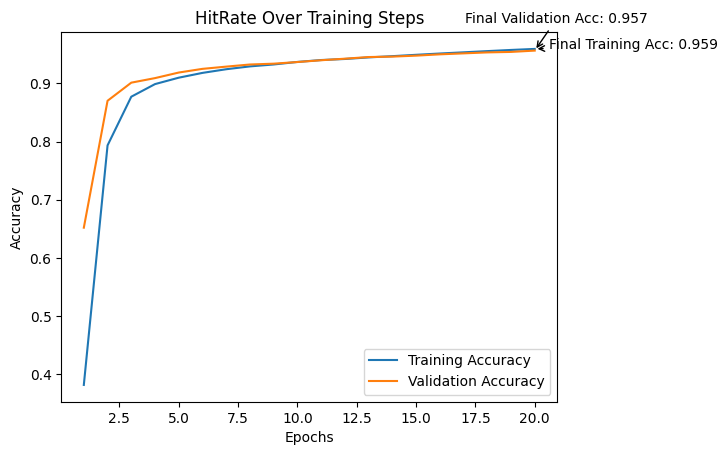

In [ ]:
final_training_ac, final_validation_ac = create_plot(history, "plots/hitrate_plot_Exp10.png")

In [ ]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 2s 5ms/step
Train Set Report
Accuracy: 95.95%
Correctly Classified: 46054
Missclassified: 1946


Validation Set Report
Accuracy: 95.66%
Correctly Classified: 11478
Missclassified: 522


Test Set Report
Accuracy: 95.36%
Correctly Classified: 9536
Missclassified: 464


In [ ]:
pkl.dump(model, open("models/Dense_ReLU_10.pkl", 'wb'))

# Exp 1.1 Two Hidden Layer Dense Network with ReLU and SGD Loss

In [ ]:
model = define_dense_model([256,64], 'relu', 'sgd', 0.1)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 256)               200960    
                                                                 
 dense_41 (Dense)            (None, 64)                16448     
                                                                 
 dense_42 (Dense)            (None, 10)                650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train_one_hot, epochs = 20, validation_data = (X_val, y_val_one_hot), batch_size=64 )

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.0729 - accuracy: 0.4680 - val_loss: 0.0453 - val_accuracy: 0.7522
Epoch 2/20
750/750 [==============================] - 4s 6ms/step - loss: 0.0322 - accuracy: 0.8183 - val_loss: 0.0220 - val_accuracy: 0.8733
Epoch 3/20
750/750 [==============================] - 5s 6ms/step - loss: 0.0207 - accuracy: 0.8776 - val_loss: 0.0169 - val_accuracy: 0.8983
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 0.0171 - accuracy: 0.8953 - val_loss: 0.0148 - val_accuracy: 0.9077
Epoch 5/20
750/750 [==============================] - 6s 8ms/step - loss: 0.0152 - accuracy: 0.9057 - val_loss: 0.0135 - val_accuracy: 0.9150
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.0140 - accuracy: 0.9128 - val_loss: 0.0127 - val_accuracy: 0.9193
Epoch 7/20
750/750 [==============================] - 4s 5ms/step - loss: 0.0131 - accuracy: 0.9182 - val_loss: 0.0120 - val_accuracy: 0.9231
Epoch 

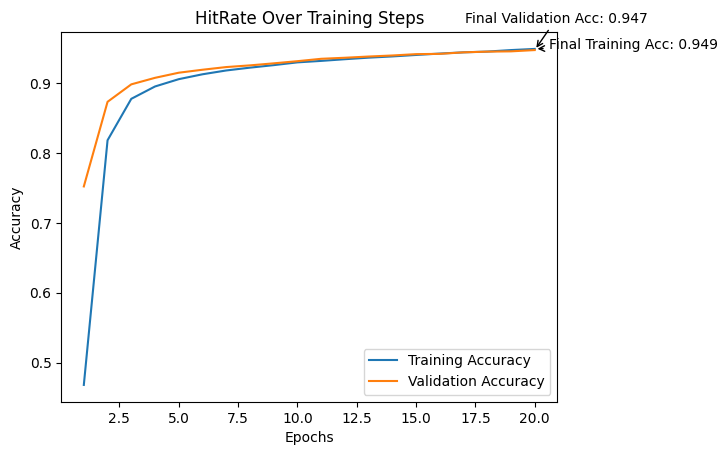

In [ ]:
final_training_ac, final_validation_ac = create_plot(history, "plots/hitrate_plot_Exp11.png")

In [ ]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 1s 3ms/step
Train Set Report
Accuracy: 94.91%
Correctly Classified: 45555
Missclassified: 2445


Validation Set Report
Accuracy: 94.74%
Correctly Classified: 11368
Missclassified: 632


Test Set Report
Accuracy: 94.39%
Correctly Classified: 9439
Missclassified: 561


# Exp 1.2: Two-Hidden-Layer Dense Network with Less Hidden Units

In [ ]:
model = define_dense_model([128,32],'relu', 'sgd', 0.1)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 128)               100480    
                                                                 
 dense_44 (Dense)            (None, 32)                4128      
                                                                 
 dense_45 (Dense)            (None, 10)                330       
                                                                 
Total params: 104,938
Trainable params: 104,938
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train_one_hot, epochs = 20, validation_data = (X_val, y_val_one_hot), batch_size=64 )

Epoch 1/20
750/750 [==============================] - 4s 4ms/step - loss: 0.0760 - accuracy: 0.4231 - val_loss: 0.0537 - val_accuracy: 0.6787
Epoch 2/20
750/750 [==============================] - 5s 6ms/step - loss: 0.0403 - accuracy: 0.7518 - val_loss: 0.0290 - val_accuracy: 0.8317
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0250 - accuracy: 0.8531 - val_loss: 0.0196 - val_accuracy: 0.8865
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0192 - accuracy: 0.8838 - val_loss: 0.0164 - val_accuracy: 0.9002
Epoch 5/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0167 - accuracy: 0.8976 - val_loss: 0.0148 - val_accuracy: 0.9096
Epoch 6/20
750/750 [==============================] - 4s 5ms/step - loss: 0.0152 - accuracy: 0.9050 - val_loss: 0.0137 - val_accuracy: 0.9130
Epoch 7/20
750/750 [==============================] - 4s 5ms/step - loss: 0.0142 - accuracy: 0.9109 - val_loss: 0.0130 - val_accuracy: 0.9167
Epoch 

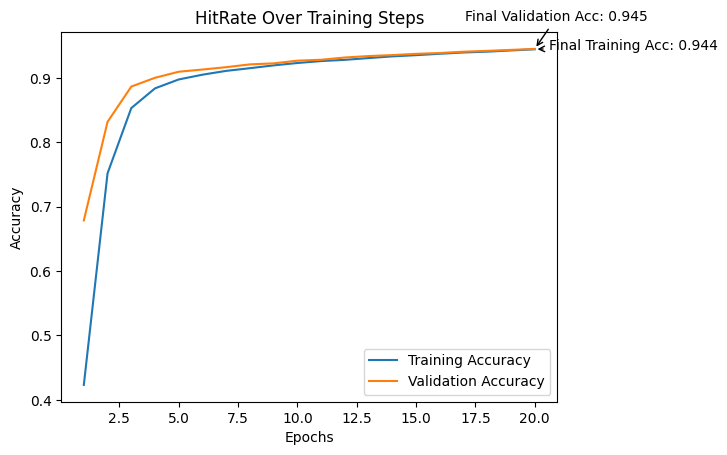

In [ ]:
final_training_ac, final_validation_ac = create_plot(history, "plots/hitrate_plot_Exp12.png")

In [ ]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 1s 2ms/step
Train Set Report
Accuracy: 94.44%
Correctly Classified: 45331
Missclassified: 2669


Validation Set Report
Accuracy: 94.50%
Correctly Classified: 11339
Missclassified: 661


Test Set Report
Accuracy: 94.46%
Correctly Classified: 9446
Missclassified: 554


# Exp 1.3: Least Cost Model (32 Dense Unit Only)

In [ ]:
model = define_dense_model([32], 'relu', 'sgd', 0.1)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 32)                25120     
                                                                 
 dense_47 (Dense)            (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train_one_hot, epochs = 20, validation_data = (X_val, y_val_one_hot), batch_size=64 )

Epoch 1/20
750/750 [==============================] - 2s 3ms/step - loss: 0.0727 - accuracy: 0.5101 - val_loss: 0.0494 - val_accuracy: 0.7387
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0398 - accuracy: 0.7665 - val_loss: 0.0320 - val_accuracy: 0.7996
Epoch 3/20
750/750 [==============================] - 3s 3ms/step - loss: 0.0310 - accuracy: 0.8026 - val_loss: 0.0277 - val_accuracy: 0.8177
Epoch 4/20
750/750 [==============================] - 2s 3ms/step - loss: 0.0276 - accuracy: 0.8177 - val_loss: 0.0246 - val_accuracy: 0.8352
Epoch 5/20
750/750 [==============================] - 2s 3ms/step - loss: 0.0233 - accuracy: 0.8542 - val_loss: 0.0197 - val_accuracy: 0.8818
Epoch 6/20
750/750 [==============================] - 2s 3ms/step - loss: 0.0195 - accuracy: 0.8840 - val_loss: 0.0170 - val_accuracy: 0.8988
Epoch 7/20
750/750 [==============================] - 2s 3ms/step - loss: 0.0175 - accuracy: 0.8954 - val_loss: 0.0156 - val_accuracy: 0.9050
Epoch 

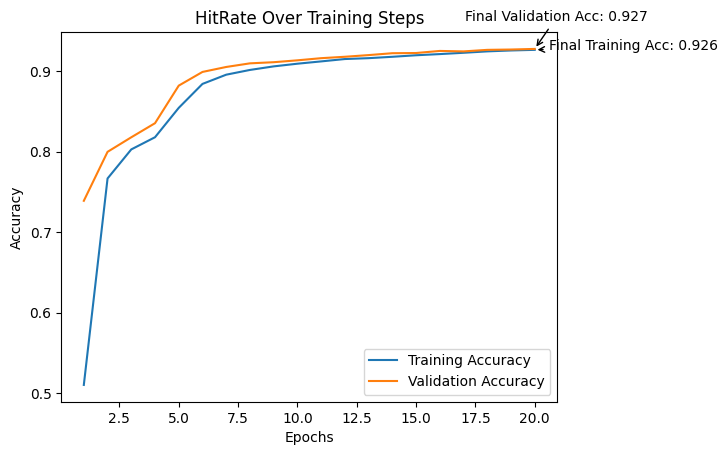

In [ ]:
final_training_ac, final_validation_ac = create_plot(history, "plots/hitrate_plot_Exp13.png")

In [ ]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 1s 2ms/step
Train Set Report
Accuracy: 92.63%
Correctly Classified: 44461
Missclassified: 3539


Validation Set Report
Accuracy: 92.74%
Correctly Classified: 11129
Missclassified: 871


Test Set Report
Accuracy: 92.95%
Correctly Classified: 9295
Missclassified: 705


<p>
We note that the accuracy is fluctuating by very low percentage between the previous experiments, however the number of trainable parameters has big variations.
So, it's better to use the Model which has least trainable parameters, so less cost and computation.
</p>

#Tuning Dense Model with Adam Oprimizer

In [ ]:
# Search Space of Hyperparameters
hp = HyperParameters()
hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
hp.Choice('batch_size', values=[16, 32, 64])
hp.Choice('hidden_units', values=[64, 128, 256])
hp.Choice('num_hidden_layers', values=[2, 3, 4])

# Define the model-building function
def build_model(hp):
    model = Sequential()
    for _ in range(hp.get('num_hidden_layers')):
        model.add(Dense(units=hp.get('hidden_units')))
        model.add(Activation('relu'))
    model.add(Dense(units=10))
    model.add(Activation('softmax'))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.get('learning_rate')),
        loss='mean_squared_error',
        metrics=['accuracy']
    )
    return model

In [ ]:
#hyperparameter search
tuner = Hyperband(build_model, hyperparameters=hp, objective='val_accuracy', max_epochs=10)
tuner.search(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=hp.get('batch_size'))

In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
# Print the selected hyperparameter values
print("Selected Learning Rate:", best_hp.get('learning_rate'))
print("Selected Batch Size:", best_hp.get('batch_size'))
print("Selected Hidden Units:", best_hp.get('hidden_units'))
print("Selected Number of Hidden Layers:", best_hp.get('num_hidden_layers'))

Selected Learning Rate: 0.001
Selected Batch Size: 32
Selected Hidden Units: 128
Selected Number of Hidden Layers: 4


# Exp 2.0: One Layer Dense Network with ADAM Optimizer (Best Cost)

In [79]:
model = define_dense_model([32], 'relu', 'adam', 0.001)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 32)                25120     
                                                                 
 dense_55 (Dense)            (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
history = model.fit(X_train, y_train_one_hot, epochs = 20, validation_data = (X_val, y_val_one_hot), batch_size=128 )

Epoch 1/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0243 - accuracy: 0.8442 - val_loss: 0.0123 - val_accuracy: 0.9215
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0120 - accuracy: 0.9245 - val_loss: 0.0102 - val_accuracy: 0.9364
Epoch 3/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0102 - accuracy: 0.9356 - val_loss: 0.0093 - val_accuracy: 0.9428
Epoch 4/20
375/375 [==============================] - 2s 5ms/step - loss: 0.0090 - accuracy: 0.9436 - val_loss: 0.0085 - val_accuracy: 0.9467
Epoch 5/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0081 - accuracy: 0.9496 - val_loss: 0.0082 - val_accuracy: 0.9500
Epoch 6/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0073 - accuracy: 0.9546 - val_loss: 0.0075 - val_accuracy: 0.9538
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0068 - accuracy: 0.9583 - val_loss: 0.0071 - val_accuracy: 0.9554
Epoch 

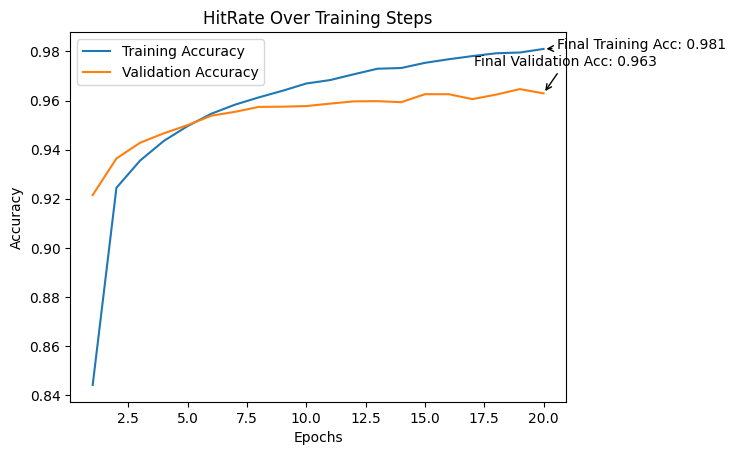

In [81]:
final_training_ac, final_validation_ac = create_plot(history, "plots/hitrate_plot_Exp20.png")

In [82]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 0s 1ms/step
Train Set Report
Accuracy: 98.10%
Correctly Classified: 47088
Missclassified: 912


Validation Set Report
Accuracy: 96.29%
Correctly Classified: 11555
Missclassified: 445


Test Set Report
Accuracy: 96.21%
Correctly Classified: 9621
Missclassified: 379


In [83]:
pkl.dump(model,open("models/bestCostModel20.pkl", 'wb'))

# Exp 2.1: More Dense Units (Best Accuracy)

In [84]:
model = define_dense_model([256,128,64,32],'relu','adam',0.001)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 256)               200960    
                                                                 
 dense_57 (Dense)            (None, 128)               32896     
                                                                 
 dense_58 (Dense)            (None, 64)                8256      
                                                                 
 dense_59 (Dense)            (None, 32)                2080      
                                                                 
 dense_60 (Dense)            (None, 10)                330       
                                                                 
Total params: 244,522
Trainable params: 244,522
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
history = model.fit(X_train, y_train_one_hot, epochs = 10, validation_data = (X_val, y_val_one_hot), batch_size=32 )

Epoch 1/10
1500/1500 [==============================] - 16s 10ms/step - loss: 0.0121 - accuracy: 0.9190 - val_loss: 0.0063 - val_accuracy: 0.9582
Epoch 2/10
1500/1500 [==============================] - 17s 11ms/step - loss: 0.0057 - accuracy: 0.9634 - val_loss: 0.0062 - val_accuracy: 0.9604
Epoch 3/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0044 - accuracy: 0.9716 - val_loss: 0.0045 - val_accuracy: 0.9711
Epoch 4/10
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0037 - accuracy: 0.9764 - val_loss: 0.0050 - val_accuracy: 0.9690
Epoch 5/10
1500/1500 [==============================] - 17s 11ms/step - loss: 0.0032 - accuracy: 0.9793 - val_loss: 0.0046 - val_accuracy: 0.9701
Epoch 6/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.0028 - accuracy: 0.9824 - val_loss: 0.0041 - val_accuracy: 0.9737
Epoch 7/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.0025 - accuracy: 0.9845 - val_loss: 0.0051 - val

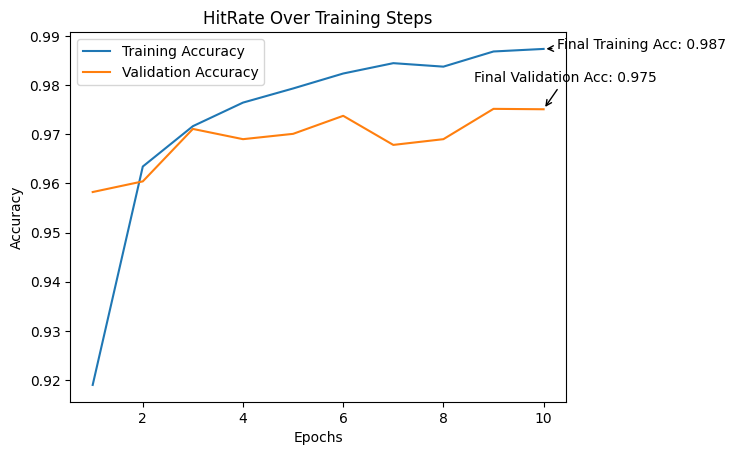

In [86]:
final_training_ac, final_validation_ac = create_plot(history, "plots/hitrate_plot_Exp21.png")

In [87]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 1s 3ms/step
Train Set Report
Accuracy: 98.74%
Correctly Classified: 47392
Missclassified: 608


Validation Set Report
Accuracy: 97.51%
Correctly Classified: 11701
Missclassified: 299


Test Set Report
Accuracy: 97.60%
Correctly Classified: 9760
Missclassified: 240


In [88]:
pkl.dump(model, open("models/Dense_Adam_BestAccuracy_21.pkl", 'wb'))

Better to use less cost model

# Testing Other Activations

## Exp 2.3: SELU Activation

In [89]:
model = define_dense_model([32], 'selu', 'adam', 0.001)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 32)                25120     
                                                                 
 dense_62 (Dense)            (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
history = model.fit(X_train, y_train_one_hot, epochs = 20, validation_data = (X_val, y_val_one_hot), batch_size=128 )

Epoch 1/20
375/375 [==============================] - 2s 4ms/step - loss: 0.0225 - accuracy: 0.8546 - val_loss: 0.0130 - val_accuracy: 0.9156
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0126 - accuracy: 0.9199 - val_loss: 0.0111 - val_accuracy: 0.9270
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0110 - accuracy: 0.9301 - val_loss: 0.0102 - val_accuracy: 0.9358
Epoch 4/20
375/375 [==============================] - 1s 4ms/step - loss: 0.0099 - accuracy: 0.9366 - val_loss: 0.0098 - val_accuracy: 0.9362
Epoch 5/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0090 - accuracy: 0.9433 - val_loss: 0.0090 - val_accuracy: 0.9433
Epoch 6/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0083 - accuracy: 0.9474 - val_loss: 0.0082 - val_accuracy: 0.9472
Epoch 7/20
375/375 [==============================] - 2s 6ms/step - loss: 0.0077 - accuracy: 0.9521 - val_loss: 0.0078 - val_accuracy: 0.9503
Epoch 

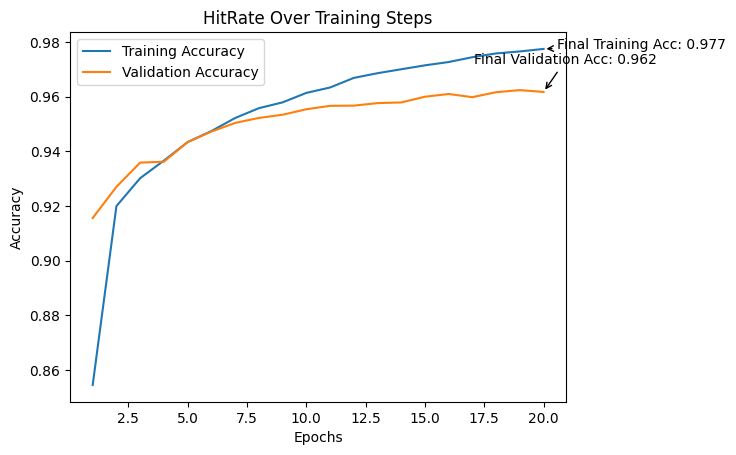

In [91]:
final_training_ac, final_validation_ac = create_plot(history, "plots/hitrate_plot_Exp23.png")

In [92]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 1s 3ms/step
Train Set Report
Accuracy: 97.74%
Correctly Classified: 46914
Missclassified: 1086


Validation Set Report
Accuracy: 96.17%
Correctly Classified: 11539
Missclassified: 461


Test Set Report
Accuracy: 96.24%
Correctly Classified: 9624
Missclassified: 376


Almost Same Results

## Exp 2.4: ELU Activation

In [94]:
model = define_dense_model([32], 'elu', 'adam', 0.001)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 32)                25120     
                                                                 
 dense_68 (Dense)            (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
history = model.fit(X_train, y_train_one_hot, epochs = 10, validation_data = (X_val, y_val_one_hot), batch_size=32 )

Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0169 - accuracy: 0.8918 - val_loss: 0.0109 - val_accuracy: 0.9310
Epoch 2/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0103 - accuracy: 0.9343 - val_loss: 0.0089 - val_accuracy: 0.9437
Epoch 3/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0082 - accuracy: 0.9478 - val_loss: 0.0079 - val_accuracy: 0.9503
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0071 - accuracy: 0.9552 - val_loss: 0.0073 - val_accuracy: 0.9546
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0061 - accuracy: 0.9617 - val_loss: 0.0067 - val_accuracy: 0.9585
Epoch 6/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0054 - accuracy: 0.9664 - val_loss: 0.0061 - val_accuracy: 0.9613
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0049 - accuracy: 0.9708 - val_loss: 0.0062 - val_accuracy:

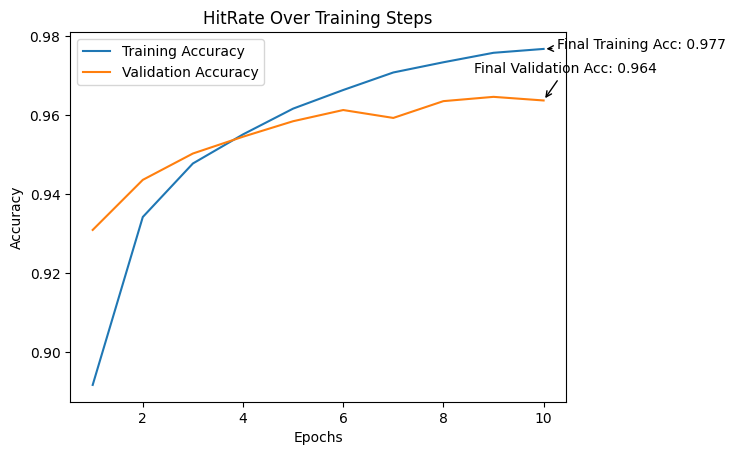

In [96]:
final_training_ac, final_validation_ac = create_plot(history, "plots/hitrate_plot_Exp24.png")

In [97]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 0s 1ms/step
Train Set Report
Accuracy: 97.68%
Correctly Classified: 46886
Missclassified: 1114


Validation Set Report
Accuracy: 96.38%
Correctly Classified: 11565
Missclassified: 435


Test Set Report
Accuracy: 96.39%
Correctly Classified: 9639
Missclassified: 361


Almost Same Results

## Exp 2.5: Swish Activation Function

In [98]:
from tensorflow.keras.layers import Activation

# Define the Swish activation function
def swish(x):
    return x * tf.keras.activations.sigmoid(x)

In [102]:
# Create a Sequential model with Swish activation
model = Sequential([
    Dense(units=64, input_dim=784),
    Activation(swish),
    Dense(units=32),
    Activation(swish),
    Dense(units=10, activation='softmax')
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 64)                50240     
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dense_77 (Dense)            (None, 32)                2080      
                                                                 
 activation_6 (Activation)   (None, 32)                0         
                                                                 
 dense_78 (Dense)            (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [103]:
history = model.fit(X_train, y_train_one_hot, epochs = 20, validation_data = (X_val, y_val_one_hot), batch_size=32 )

Epoch 1/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0144 - accuracy: 0.9059 - val_loss: 0.0091 - val_accuracy: 0.9394
Epoch 2/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0075 - accuracy: 0.9528 - val_loss: 0.0067 - val_accuracy: 0.9564
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0058 - accuracy: 0.9628 - val_loss: 0.0061 - val_accuracy: 0.9617
Epoch 4/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0047 - accuracy: 0.9699 - val_loss: 0.0062 - val_accuracy: 0.9598
Epoch 5/20
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0040 - accuracy: 0.9750 - val_loss: 0.0052 - val_accuracy: 0.9663
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0036 - accuracy: 0.9779 - val_loss: 0.0048 - val_accuracy: 0.9689
Epoch 7/20
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0031 - accuracy: 0.9810 - val_loss: 0.0056 - val_accurac

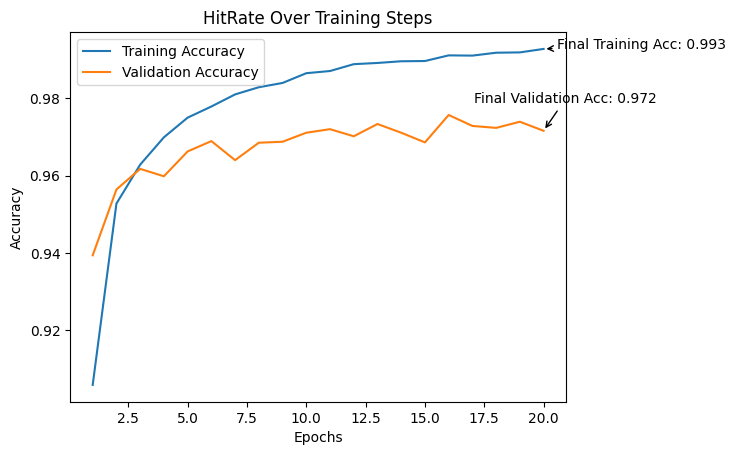

In [104]:
final_training_ac, final_validation_ac = create_plot(history, "plots/hitrate_plot_Exp25.png")

In [105]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 1s 3ms/step
Train Set Report
Accuracy: 99.27%
Correctly Classified: 47651
Missclassified: 349


Validation Set Report
Accuracy: 97.16%
Correctly Classified: 11658
Missclassified: 342


Test Set Report
Accuracy: 97.05%
Correctly Classified: 9705
Missclassified: 295


In [106]:
pkl.dump(model, open("models/bestCostAccTO_25.pkl", 'wb'))

Best Cost/Accuracy TradeOff :)